## Procesamiento de los videos
En esta esta etapa buscamos extraer los cuadros de los videos para poder hacer aplicar la técnica entre cada uno de los cuadros.  

In [1]:
import sys
import os
import subprocess

import cv2
import numpy as np
from datetime import timedelta


Establecemos la cantidad de cuadros que esperamos extraer por segundo:

In [2]:
CUADROS_GUARDADOS_POR_SGUNDO = 10

In [3]:
def formato_timedelta(td):
    """Función de utilidad para dar formato a los objetos de timedelta en forma (e.g 00:00:20.05) 
    Se omiten los microsegundos pero se dejan los milisegundos"""
    tiempo = str(td)
    try:
        tiempo, ms = tiempo.split(".")
    except ValueError:
        return tiempo + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{tiempo}.{ms:02}".replace(":", "-")


 Como los videos provienen en realidad de un archivo H264, se tienen que obtener datos importantes para poder convertir nuestro video a imagen. A continuación hay dos funciones auxiliares que nos ayudan en esta tarea:

In [4]:
def obtener_frame_rate(archivo_de_video):
    """Función que usa ffprobe para conocer el número de cuadros por segundo con los qu se grabo el vídeo"""
    if not os.path.exists(archivo_de_video):
        sys.stderr.write("ERROR: ¡El archivo no  %r se encontró!" % (archivo_de_video,))
        return -1         
    out = subprocess.check_output(["ffprobe",archivo_de_video,"-v","0","-select_streams","v","-print_format","flat","-show_entries","stream=r_frame_rate"])
    rate = out.split(b'=')[1].strip()[1:-1].split(b'/')
    if len(rate)==1:
        return float(rate[0])
    if len(rate)==2:
        return float(rate[0])/float(rate[1])
    return -1

In [5]:
def obtener_numero_de_frames(archivo_de_video):
    """Función que usa ffprobe para recorrer todo el vídeo original y retorna el número de cuadros totales del vídeo"""
    if not os.path.exists(archivo_de_video):
        sys.stderr.write("ERROR: ¡El archivo no  %r se encontró!" % (archivo_de_video,))
        return -1     
    out = subprocess.check_output(["ffprobe", "-show_streams", "-count_frames", "-pretty",  archivo_de_video])
    numero_frames = out.split(b'=')[40].splitlines()[0]
    
    return float(numero_frames)

In [6]:
def obtener_duracion_de_cuadros_por_guardar(captura, fps, archivo_de_video):
    """Función que retorna la lista de las duraciones de los cuadros a guardar"""
    s = []
    # Obtenemos la duración de captura dividada por el número de cuadros por segundo
    fps_meta_data = captura.get(cv2.CAP_PROP_FPS)
    numero_de_cuadros = captura.get(cv2.CAP_PROP_FRAME_COUNT) 
    if (fps_meta_data ==0):
        fps_meta_data = obtener_frame_rate(archivo_de_video)
    
    if (numero_de_cuadros ==0 ):
        numero_de_cuadros = obtener_numero_de_frames(archivo_de_video)
    
    clip_duration = numero_de_cuadros / fps_meta_data
    # usamos np.arange() para hacer pasos de tipo folantante
    for i in np.arange(0, clip_duration, 1 / fps):
        s.append(i)
    return s

In [7]:
def video_a_cuadros(archivo_de_video, mensaje_cuenta = True):
    nombre_archivo, _ = os.path.splitext(archivo_de_video)
    nombre_archivo += "-imagenes"
    # Creamos un folder con el nombre del video
    if not os.path.isdir(nombre_archivo):
        os.mkdir(nombre_archivo)
    # leemos el archivo de video    
    captura = cv2.VideoCapture(archivo_de_video)
    # Obtenemos los FPS del video
    fps = captura.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        fps = obtener_frame_rate(archivo_de_video)
    # Si esta la cantidad de FPS a guardar es mayor que los FPS del video, dejamos el máximo de FPS del vídeo.
    cuadros_guardadados_por_segundo = min(fps, CUADROS_GUARDADOS_POR_SGUNDO)
    
    # obtenemos la liste de la duración de los cuadros a guardar
    duracion_de_cuadros_guardados = obtener_duracion_de_cuadros_por_guardar(captura, cuadros_guardadados_por_segundo, archivo_de_video)

    cuenta = 0
    cuenta_de_imagen = 0 
    while True:
        es_leido, cuadro = captura.read()
        if not es_leido:
            # Nos salimos si no hay más cuadros que leer 
            break
        # Obtenemos la duruación dividada por la cuenta de cuadros
        duracion_de_cuadros = cuenta / fps
        try:
            # get the earliest duration to save
            tiempo_de_cuadro = duracion_de_cuadros_guardados[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if duracion_de_cuadros >= tiempo_de_cuadro:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            duracion_de_cuadros_con_formato =  formato_timedelta(timedelta(seconds=duracion_de_cuadros))
            cuenta_de_imagen = cuenta_de_imagen + 1
            if mensaje_cuenta is True:
                mensaje = cuenta_de_imagen
            else:
                mensaje = duracion_de_cuadros_con_formato
            cv2.imwrite(os.path.join(nombre_archivo, f"frame{mensaje}.jpg"), cuadro) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                duracion_de_cuadros_guardados.pop(0)
            except IndexError:
                pass
        # increment the frame count
        cuenta += 1

In [8]:
video_a_cuadros("../video2.mp4")


## Mapa vectorial PIV

En esta sección se aplicará de facto el procesamiento que recomienta open-PIV.

In [9]:
from openpiv import windef

configuracion = windef.Settings()

In [10]:
"Configuración de los datos"
# Carpeta con las imagenes que se procesarán
configuracion.filepath_images = '../video2-imagenes'
# Carpeta para guardar la salida
configuracion.save_path = '../video2-imagenes'
# Nombre de la base para guardar los resutlados 
configuracion.save_folder_suffix = 'PIV'
# Format and Image Sequence
configuracion.frame_pattern_a = 'frame194.jpg'
configuracion.frame_pattern_b = 'frame197.jpg'

In [11]:
"Región de interés"
configuracion.ROI = 'full'

"Procesamiento de las imágenes"
configuracion.dynamic_masking_method = 'None'
configuracion.dynamic_masking_threshold = 0.005
configuracion.dynamic_masking_filter_size = 7

In [12]:
"Parámetros de procesamiento"
configuracion.correlation_method = 'circular'  # 'circular' o 'linear'
configuracion.normalized_correlation = False
configuracion.num_iterations = 2 # seleccionar el número de pases PIV
configuracion.windowsizes = (64, 32, 16)
# Agregamos el tamaño de la ventana de interrogación para cada pase.
# Por el momento, debería ser una potencia de 2
# si dura más de n iteraciones, el resto se ignora.
# La superposición de la ventana de interrogación para cada pase.
configuracion.overlap = (32, 16, 8) # Esta es una superposición del 50%
# La superoposición Tiene que ser un valor con base dos. En general, el tamaño de ventana/2 es una buena opción.

# Método utilizado para la interpolación de subpíxeles: 'gaussian','centroid','parabolic'
configuracion.subpixel_method = 'gaussian'
# 'simétrico' o 'segunda imagen', 'simétrico' divide la deformación en ambas imágenes
# mientras que 'segunda imagen' solo deforma la segunda imagen.
configuracion.deformation_method = 'symmetric' #  'symmetric' o 'second image'
# orden de la interpolación de la imagen para la deformación de la ventana
configuracion.interpolation_order = 3
configuracion.scaling_factor = 1 # factor de escala píxel/metro
configuracion.dt = 1 # tiempo entre fotogramas (en segundos)

In [13]:
"Opciones de relación señal/ruido (solo para el último pase)"
# Es posible decidir si se debe calcular la S/N (para el último
# pase) o no
# 'Verdadero' o 'Falso' (solo para el último pase)
# configuracion.extract_sig2noise = Falso
# método utilizado para calcular la relación señal/ruido 'peak2peak' o 'peak2mean'
configuracion.sig2noise_method = 'peak2peak'
# seleccione el ancho de los píxeles enmascarados a enmascarados al lado del pico principal
configuracion.sig2noise_mask = 2
# If extract_sig2noise==False los valores en la relación señal/ruido
# columna de salida se establece en NaN

In [14]:
" Opciones de validación de vectores"
# elige si quieres hacer la validación del primer pase: Verdadero o Falso
configuracion.validation_first_pass= True
# solo efectuando la primera pasada del interrogatorio las siguientes pasadas
# en el multipass será validado
"Parámetros de validación"
# La validación se realiza en cada iteración en función de tres filtros.
# El primer filtro se basa en los rangos mínimo/máximo. Observe que estos valores están definidos en
# términos de desplazamiento mínimo y máximo en píxeles/fotogramas.
configuracion.MinMax_U_disp = (-30, 30)
configuracion.MinMax_V_disp = (-30, 30)
# El segundo filtro se basa en el umbral de ETS global
configuracion.std_threshold = 7 # umbral de la validación estándar
# El tercer filtro es la prueba de la mediana (no normalizada por el momento)
configuracion.median_threshold = 3 # umbral de la mediana de validación
# En la última iteración, se puede realizar una validación adicional basada en el S/N.
configuracion.median_size = 1 # define el tamaño de la mediana local
"Validación basada en la relación señal/ruido"
# Nota: solo disponible cuando extract_sig2noise==True y solo para el último
# pase del interrogatorio
# Habilite la validación de la relación señal/ruido. Opciones: Verdadero o Falso
configuracion.sig2noise_validate = False # Esto lleva mucho tiempo
# relación señal/ruido mínima que se necesita para un vector válido
configuracion.sig2noise_threshold = 1.2

In [25]:
"Opciones de reemplazo de valores atípicos o suavizado"
# Opciones de reemplazo para vectores que están enmascarados como no válidos por la validación
configuracion.replace_vectors = True # Habilitar el reemplazo. Elige: Verdadero o Falso
configuracion.smoothn = True # Habilita el suavizado del campo de desplazamiento
configuracion.smoothn_p = 0.55 # Este es un parámetro de suavizado
# seleccione un método para reemplazar los valores atípicos: 'media local', 'disco', 'distancia'
configuracion.filter_method = 'localmean'
# iteraciones máximas realizadas para reemplazar los valores atípicos
configuracion.max_filter_iteration = 4
configuracion.filter_kernel_size = 2 # tamaño del kernel para el método localmean
"Opciones de salida"
# Seleccione si desea guardar el campo vectorial trazado: Verdadero o Falso
configuracion.save_plot = True
# Elige si quieres ver el campo vectorial o no: Verdadero o Falso
configuracion.show_plot= True
configuracion.scale_plot = 200 # seleccione un valor para escalar el diagrama de carcaj del campo vectorial

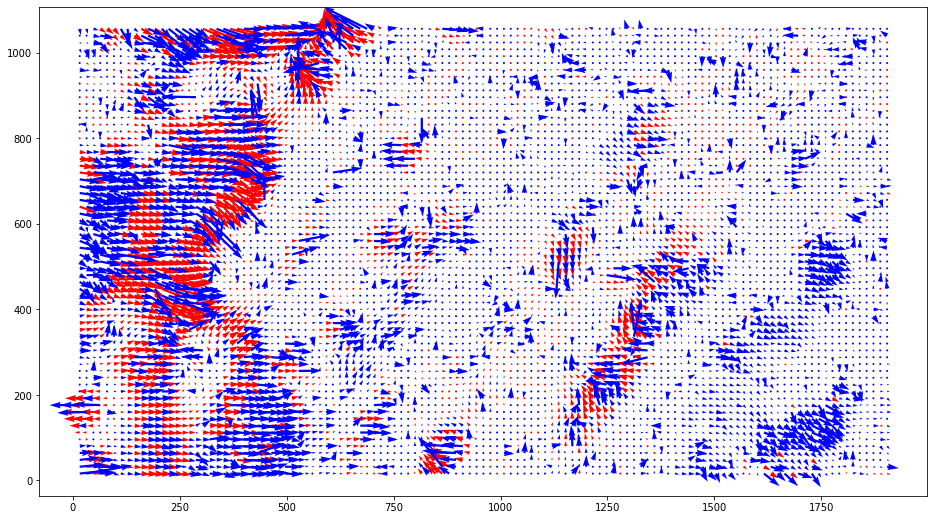

Image Pair 1
frame194.jpg frame197.jpg


In [27]:
# ejecutar el script con la configuración dada
windef.piv(configuracion)